<a href="https://colab.research.google.com/github/usamasafdarvirk/A_Deep_Learning_Approach_to_Precise_MRI_Brain_Tumor_Diagnosis/blob/main/MRI_Image_Classification_Using_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the Required Libraries

In [ ]:
import os  # Module for interacting with the operating system (e.g., file and directory operations)
from PIL import Image  # Module for opening, manipulating, and saving many different image file formats
import numpy as np  # Library for numerical operations on large, multi-dimensional arrays and matrices
import pandas as pd  # Library for data manipulation and analysis, providing data structures and operations for manipulating numerical tables and time series
import matplotlib.pyplot as plt  # Library for creating static, animated, and interactive visualizations in Python
import seaborn as sns  # Library for making statistical graphics in Python, built on top of matplotlib
from glob import glob  # Module for finding all the pathnames matching a specified pattern according to the rules used by the Unix shell
#---------------------------------------
from sklearn.model_selection import train_test_split  # Function for splitting arrays or matrices into random train and test subsets

#---------------------------------------
import tensorflow as tf  # Library for high-performance numerical computation and machine learning
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Utility for generating batches of tensor image data with real-time data augmentation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
#---------------------------------------
import warnings  # Module for controlling the warnings filter
warnings.filterwarnings("ignore")  # Suppress warnings from appearing in the output


# Importing the Images form Google Drive

In [ ]:
def generate_training_df(train_dir):
    """
    Generates a DataFrame containing image paths and their corresponding class labels from the specified training directory.

    Parameters:
    train_dir (str): Directory path containing subdirectories of images, with each subdirectory named after its class label.

    Returns:
    pd.DataFrame: A DataFrame with two columns - 'Image Path' and 'Label'.
    """
    labels, paths = zip(*[
        (class_name, os.path.join(train_dir, class_name, img_file))
        for class_name in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, class_name))
        for img_file in os.listdir(os.path.join(train_dir, class_name))
    ])

    train_df = pd.DataFrame({'Image Path': paths, 'Label': labels})
    return train_df

def generate_test_df(test_dir):
    """
    Generates a DataFrame containing image paths and their corresponding class labels from the specified test directory.

    Parameters:
    test_dir (str): Directory path containing subdirectories of images, with each subdirectory named after its class label.

    Returns:
    pd.DataFrame: A DataFrame with two columns - 'Image Path' and 'Label'.
    """
    labels, paths = zip(*[
        (class_name, os.path.join(test_dir, class_name, img_file))
        for class_name in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, class_name))
        for img_file in os.listdir(os.path.join(test_dir, class_name))
    ])

    test_df = pd.DataFrame({'Image Path': paths, 'Label': labels})
    return test_df


In [ ]:
train_df = generate_training_df('/content/drive/MyDrive/MRI_Brain_Image_Classification/Training')
train_df

,Image Path,Label
0,/content/drive/MyDrive/MRI_Brain_Image_Classif...,pituitary
1,/content/drive/MyDrive/MRI_Brain_Image_Classif...,pituitary
2,/content/drive/MyDrive/MRI_Brain_Image_Classif...,pituitary
3,/content/drive/MyDrive/MRI_Brain_Image_Classif...,pituitary
4,/content/drive/MyDrive/MRI_Brain_Image_Classif...,pituitary
...,...,...
5707,/content/drive/MyDrive/MRI_Brain_Image_Classif...,glioma
5708,/content/drive/MyDrive/MRI_Brain_Image_Classif...,glioma
5709,/content/drive/MyDrive/MRI_Brain_Image_Classif...,glioma
5710,/content/drive/MyDrive/MRI_Brain_Image_Classif...,glioma


In [ ]:
test_df = generate_test_df('/content/drive/MyDrive/MRI_Brain_Image_Classification/Testing')
test_df

,Image Path,Label
0,/content/drive/MyDrive/MRI_Brain_Image_Classif...,notumor
1,/content/drive/MyDrive/MRI_Brain_Image_Classif...,notumor
2,/content/drive/MyDrive/MRI_Brain_Image_Classif...,notumor
3,/content/drive/MyDrive/MRI_Brain_Image_Classif...,notumor
4,/content/drive/MyDrive/MRI_Brain_Image_Classif...,notumor
...,...,...
1315,/content/drive/MyDrive/MRI_Brain_Image_Classif...,pituitary
1316,/content/drive/MyDrive/MRI_Brain_Image_Classif...,pituitary
1317,/content/drive/MyDrive/MRI_Brain_Image_Classif...,pituitary
1318,/content/drive/MyDrive/MRI_Brain_Image_Classif...,pituitary


# Distribution of Images in Each Class

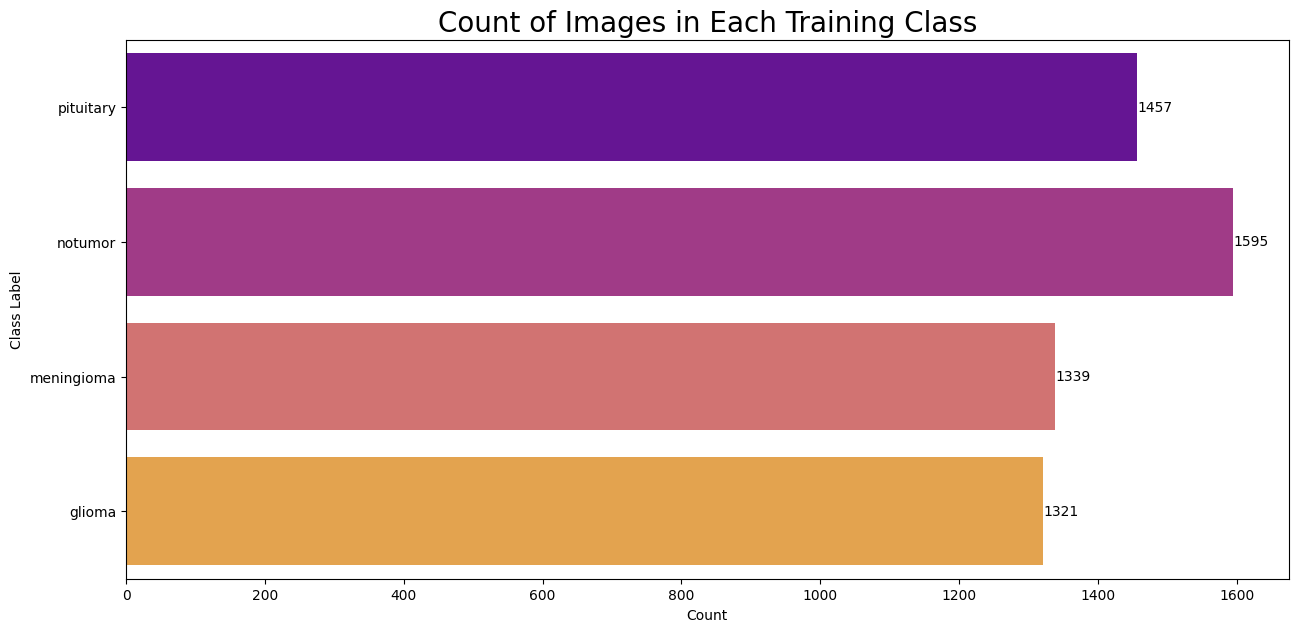

In [ ]:
def plot_class_distribution(dataframe, column_name, plot_title, color_palette='coolwarm'):
    """
    Plots the count of images in each class in the provided DataFrame.

    Parameters:
    dataframe (pd.DataFrame): DataFrame containing the class labels.
    column_name (str): Name of the column containing class labels.
    plot_title (str): Title of the plot.
    color_palette (str): Color palette to use for the plot (default is 'coolwarm').

    Returns:
    None
    """
    plt.figure(figsize=(15, 7))
    ax = sns.countplot(data=dataframe, y=column_name, palette=color_palette)

    plt.xlabel('Count')
    plt.ylabel('Class Label')
    plt.title(plot_title, fontsize=20)

    # Adding the labels to the bars
    for container in ax.containers:
        ax.bar_label(container)

    plt.show()

plot_class_distribution(train_df, 'Label', 'Count of Images in Each Training Class', color_palette='plasma')

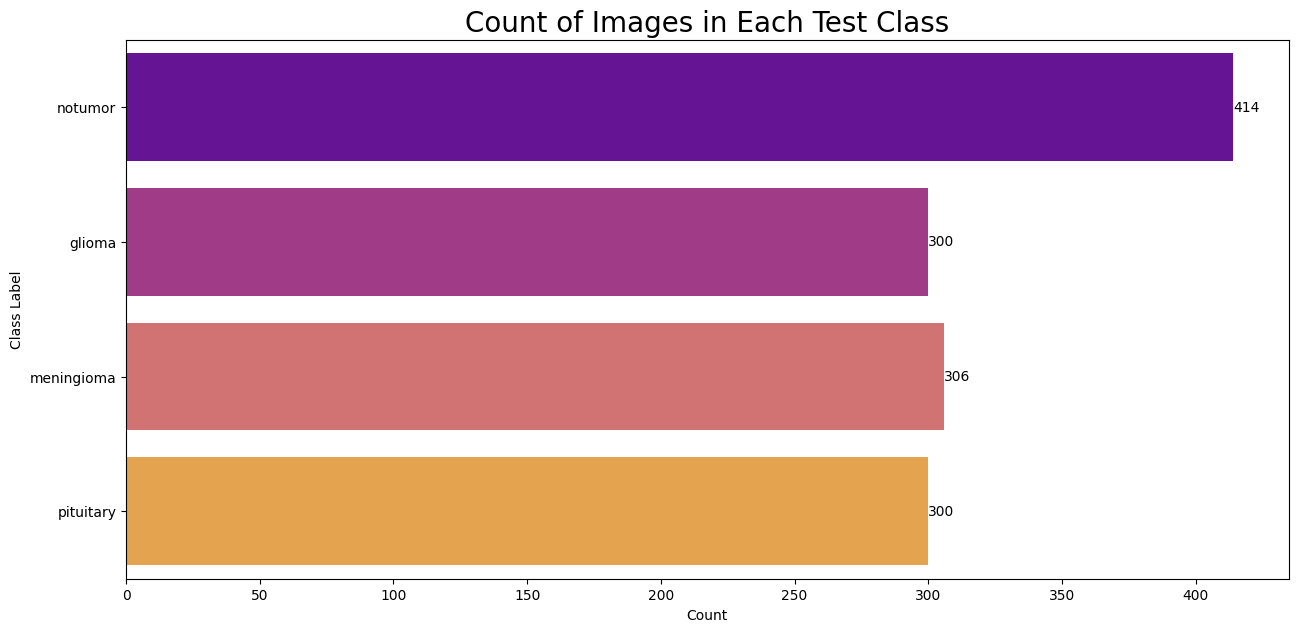

In [ ]:
plot_class_distribution(test_df, 'Label', 'Count of Images in Each Test Class', color_palette='plasma')

# Spliting the Imges to Train and Test Set

In [ ]:
valid_df, ts_df = train_test_split(test_df, train_size=0.5, random_state=20, stratify=test_df['Label'])

# Image Preprocessing -Data Augmentation

In [ ]:
# Parameters
batch_size = 32  # Number of images to be yielded from the generator per batch
img_size = (224, 224)  # Target size for each image
brightness_range = (0.8, 1.2)  # Range for random brightness adjustment
rescale_factor = 1/255  # Rescaling factor for the images

# Create ImageDataGenerators with parameters
train_val_gen = ImageDataGenerator(
    rescale=rescale_factor,
    brightness_range=brightness_range,
    rotation_range=40,  # Randomly rotate images by up to 40 degrees
    width_shift_range=0.2,  # Randomly shift images horizontally by up to 20% of the width
    height_shift_range=0.2,  # Randomly shift images vertically by up to 20% of the height
    shear_range=0.2,  # Shear transformation
    zoom_range=0.2,  # Randomly zoom into images
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest'  # Strategy for filling in newly created pixels
)

# ImageDataGenerator for test set (only rescaling)
test_gen = ImageDataGenerator(rescale=rescale_factor)

# Function to create generators from dataframes
def create_generators(tr_df, valid_df, ts_df, batch_size, img_size):
    """
    Creates training, validation, and test data generators from dataframes.

    Parameters:
    tr_df (pd.DataFrame): DataFrame containing training data.
    valid_df (pd.DataFrame): DataFrame containing validation data.
    ts_df (pd.DataFrame): DataFrame containing test data.
    batch_size (int): Number of images to be yielded from the generator per batch.
    img_size (tuple): Target size for each image.

    Returns:
    tuple: Training, validation, and test data generators.
    """
    if tr_df.empty or valid_df.empty or ts_df.empty:
        raise ValueError("One of the dataframes is empty. Please check your dataframes.")

    # Training data generator
    train_gen = train_val_gen.flow_from_dataframe(
        tr_df,
        x_col='Image Path',
        y_col='Label',
        batch_size=batch_size,
        target_size=img_size
    )

    # Validation data generator
    valid_gen = train_val_gen.flow_from_dataframe(
        valid_df,
        x_col='Image Path',
        y_col='Label',
        batch_size=batch_size,
        target_size=img_size
    )

    # Test data generator
    test_gen_flow = test_gen.flow_from_dataframe(
        ts_df,
        x_col='Image Path',
        y_col='Label',
        batch_size=16,
        target_size=img_size,
        shuffle= True
    )

    return train_gen, valid_gen, test_gen_flow

train_gen, valid_gen, test_gen_flow = create_generators(train_df, valid_df, test_df, batch_size, img_size)


Found 5712 validated image filenames belonging to 4 classes.
Found 660 validated image filenames belonging to 4 classes.
Found 1320 validated image filenames belonging to 4 classes.


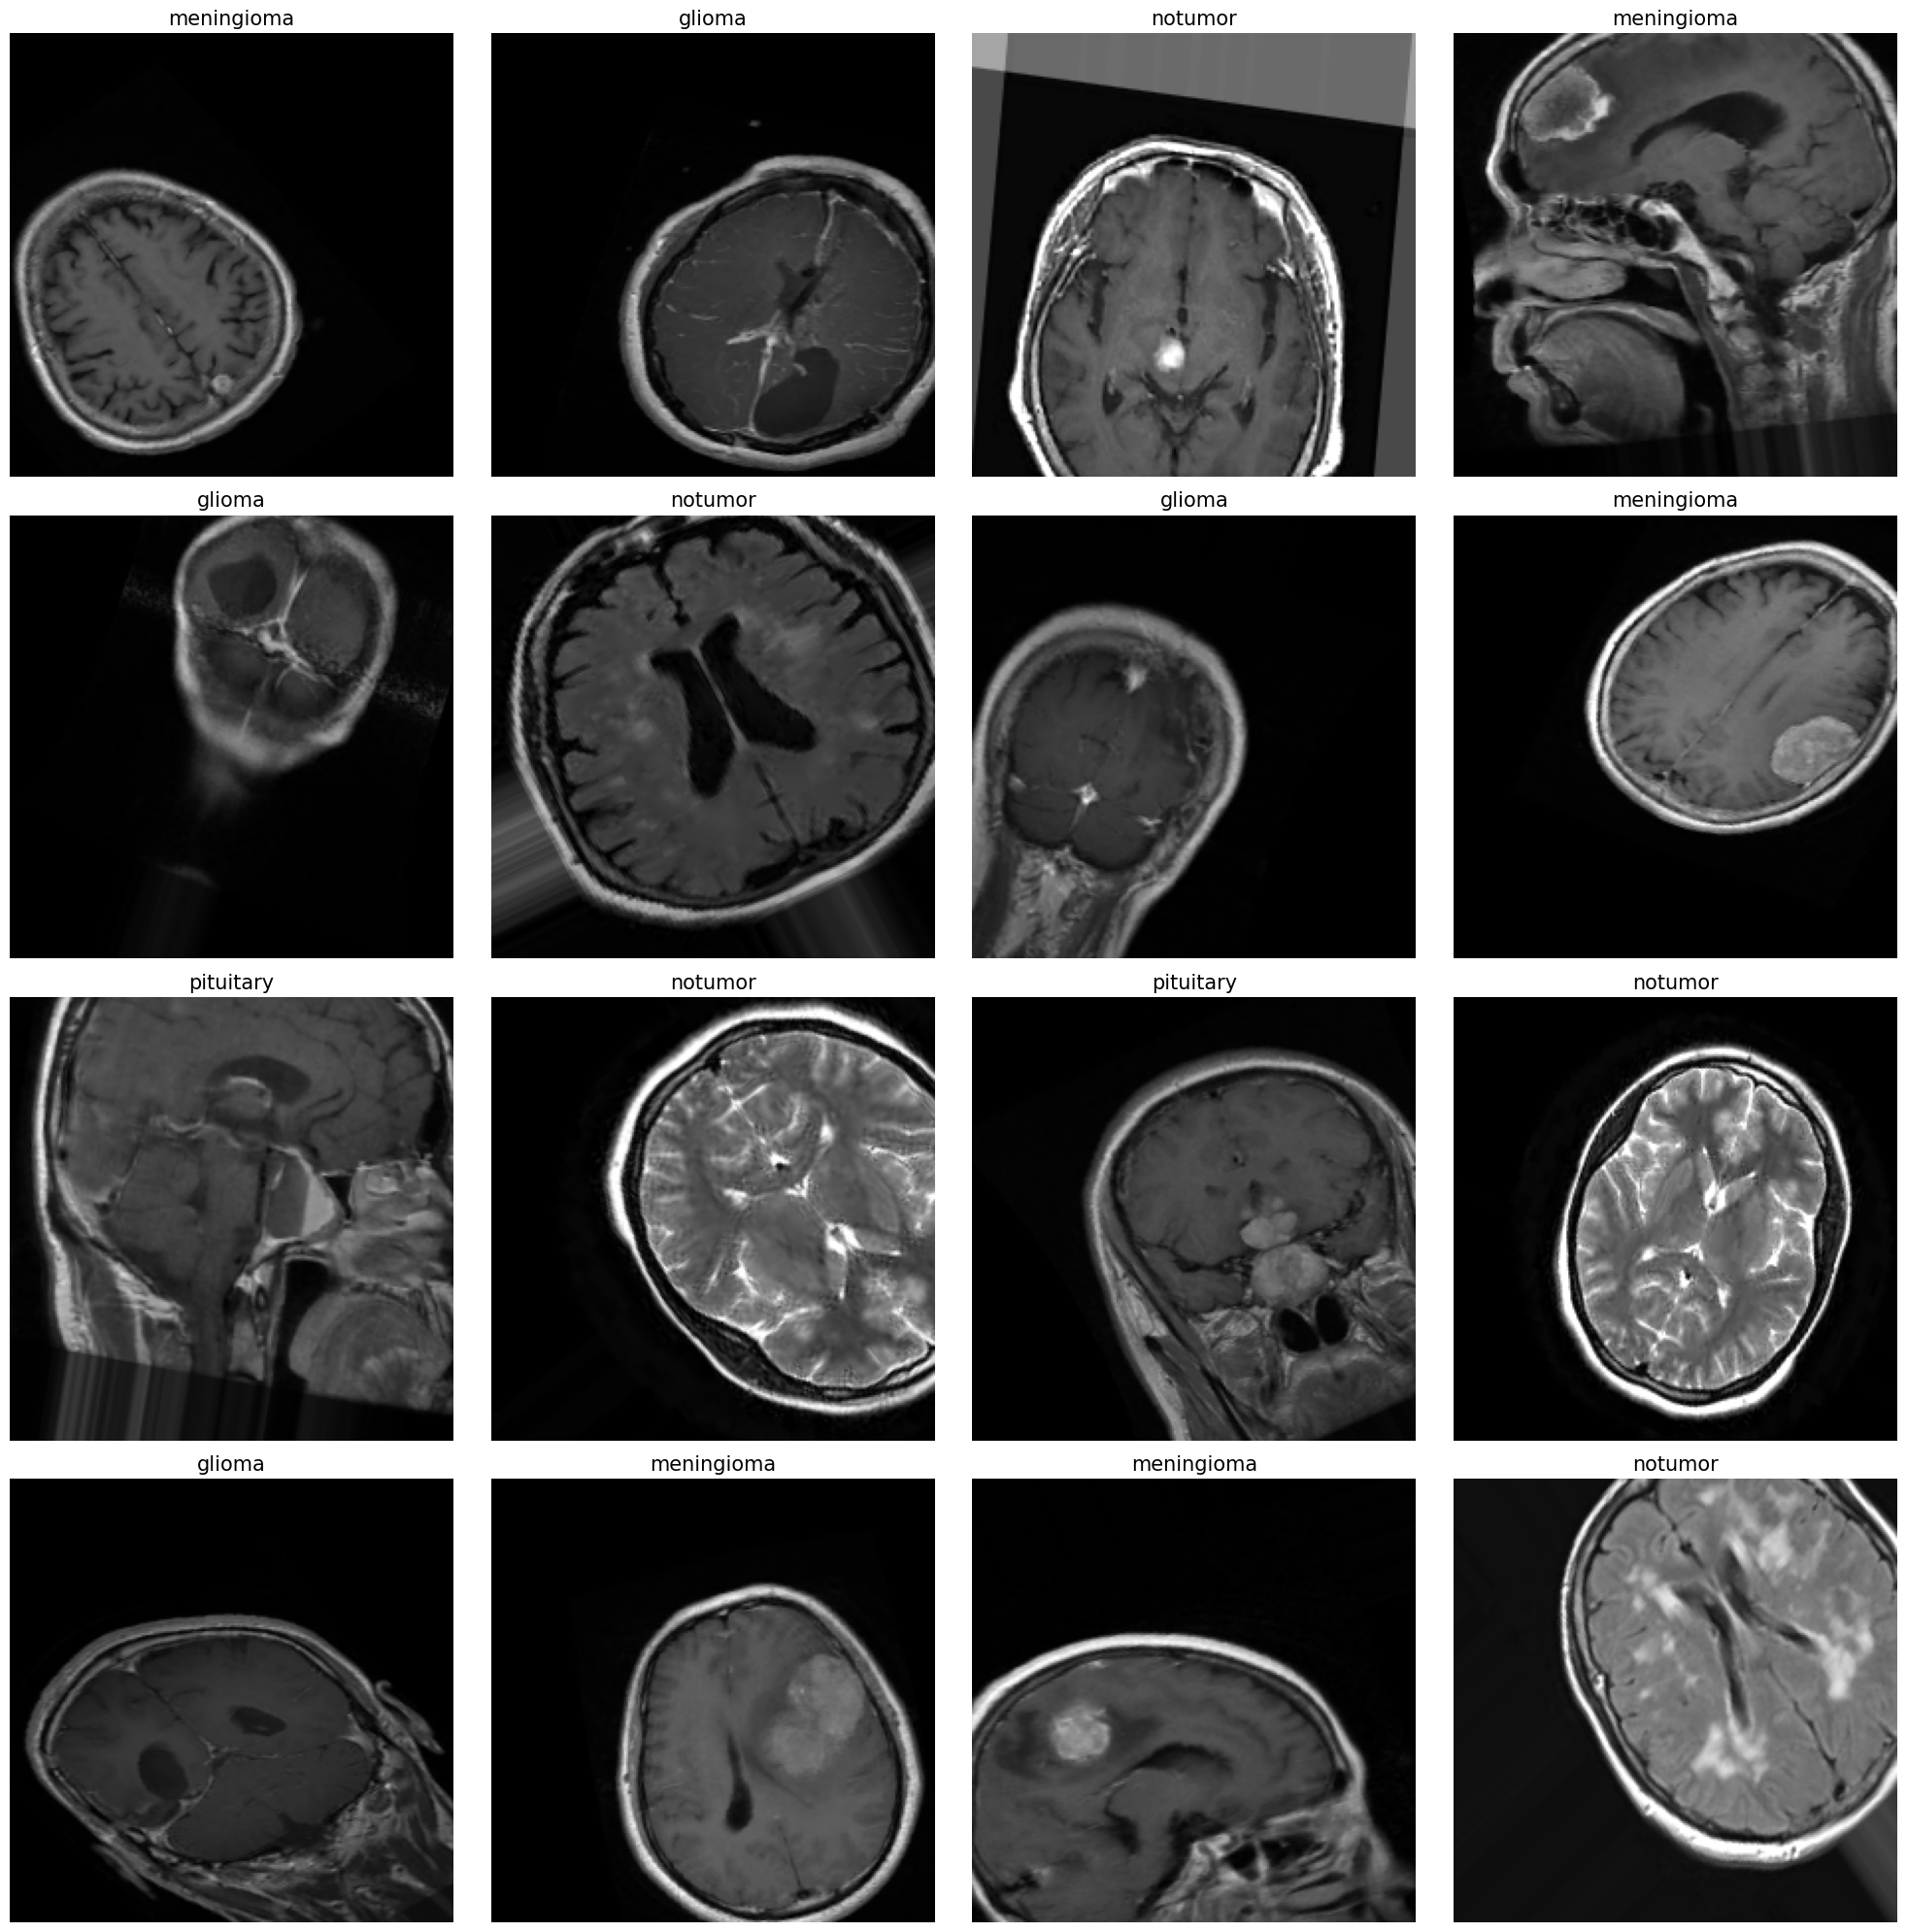

In [ ]:
def display_batch_images(generator, class_indices, batch_size=16, grid_size=(4, 4), figsize=(20, 20)):
    """
    Displays a batch of images and their corresponding class labels from the given generator.

    Parameters:
    generator (tf.keras.preprocessing.image.DirectoryIterator): The data generator to fetch images and labels from.
    class_indices (dict): A dictionary mapping class names to their corresponding indices.
    batch_size (int): Number of images to display in the batch (default is 16).
    grid_size (tuple): The size of the grid for displaying images (default is (4, 4)).
    figsize (tuple): The size of the figure for the plot (default is (20, 20)).

    Returns:
    None
    """
    # Create a list of class names from the dictionary keys
    classes = list(class_indices.keys())
    # Fetch the next batch of images and labels from the generator
    images, labels = next(generator)

    # Set the figure size for the plot
    plt.figure(figsize=figsize)

    # Iterate over the images and their corresponding labels
    for i, (image, label) in enumerate(zip(images, labels)):
        if i >= batch_size:
            break
        # Create a subplot in the grid
        plt.subplot(grid_size[0], grid_size[1], i + 1)
        # Display the image
        plt.imshow(image)
        # Find the index of the highest value in the one-hot encoded label
        class_name = classes[np.argmax(label)]
        # Set the title of the subplot to the class name
        plt.title(class_name, color='k', fontsize=15)
        plt.axis('off')  # Turn off axis

    # Display the figure with all subplots
    plt.tight_layout()
    plt.show()

class_dict = train_gen.class_indices
display_batch_images(train_gen, class_dict)


# Designing CNN Archtecture

In [ ]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

model = Sequential([
    # Block 1
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape),
    BatchNormalization(),  # Adding Batch Normalization
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
    BatchNormalization(),  # Adding Batch Normalization
    MaxPooling2D((2, 2)),
    Dropout(0.1),  # Adding Dropout

    # Block 2
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    BatchNormalization(),  # Adding Batch Normalization
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    BatchNormalization(),  # Adding Batch Normalization
    MaxPooling2D((2, 2)),
    Dropout(0.1),  # Adding Dropout

    # Block 3
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    BatchNormalization(),  # Adding Batch Normalization
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    BatchNormalization(),  # Adding Batch Normalization
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    BatchNormalization(),  # Adding Batch Normalization
    MaxPooling2D((2, 2)),
    Dropout(0.1),  # Adding Dropout

    # Block 4
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    BatchNormalization(),  # Adding Batch Normalization
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    BatchNormalization(),  # Adding Batch Normalization
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    BatchNormalization(),  # Adding Batch Normalization
    MaxPooling2D((2, 2)),
    Dropout(0.1),  # Adding Dropout

    # Block 5
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    BatchNormalization(),  # Adding Batch Normalization
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    BatchNormalization(),  # Adding Batch Normalization
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    BatchNormalization(),  # Adding Batch Normalization
    MaxPooling2D((2, 2)),
    Dropout(0.1),  # Adding Dropout

    # Fully Connected Layers
    Flatten(),
    Dense(256, activation="relu"),
    Dropout(0.2),  # Adding Dropout
    Dense(64, activation="relu"),
    Dropout(0.2),  # Adding Dropout
    Dense(class_count, activation="softmax")
])


Compiling the Model

In [ ]:
model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 batch_normalization (Batch  (None, 224, 224, 64)      256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 batch_normalization_1 (Bat  (None, 224, 224, 64)      256       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                        

Training the Network

In [ ]:
epochs = 15   # number of all epochs in training

history = model.fit(train_gen, epochs=epochs, verbose=1, validation_data=valid_gen, shuffle=False)

Epoch 1/15
 77/179 [===========>..................] - ETA: 19:06 - loss: 2.2406 - accuracy: 0.4554

Results of CNN Training

In [ ]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()